Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
length of data:  3217
+-----------------+---------+-----------+
|      Column     |  Score  |   Metric  |
+-----------------+---------+-----------+
|      cf_id      | 100.00% |  Accuracy |
|      level      | 100.00% |  Accuracy |
|      caller     | 100.00% |  Accuracy |
|    no_insert    | 100.00% |  Accuracy |
|     table_id    | 100.00% |  Accuracy |
| sequence_number | 100.00% |  Accuracy |
|  block_key_size | 100.00% |  Accuracy |
|     key_size    | 100.00% |  Accuracy |
|   block_offset  | 100.00% |  Accuracy |
|      key_id     |  99.94% | R-squared |
|       time      |  99.34% | R-squared |
|        id       |  99.13% | R-squared |
|    cache_hit    |  92.85% |  Accuracy |
|    data_size    |  52.55% |  Accuracy |
|    key_count    |  52.49% |  Accuracy |
|    block_type   |  51.99% |  Accuracy |
|    key_exist    |  51.68% |  Accuracy |
|    bloc

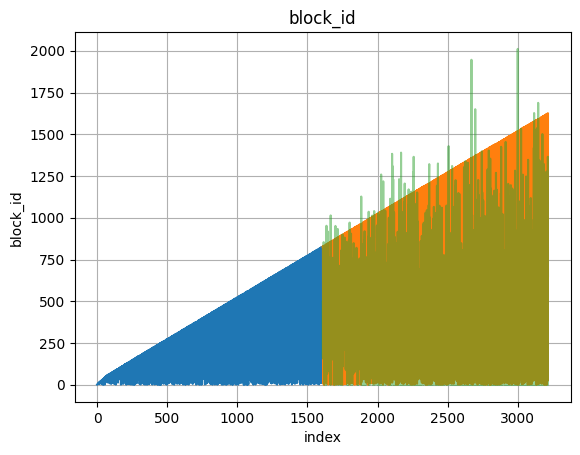

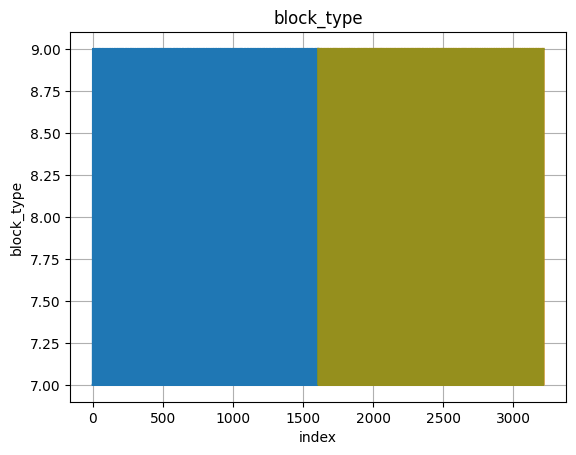

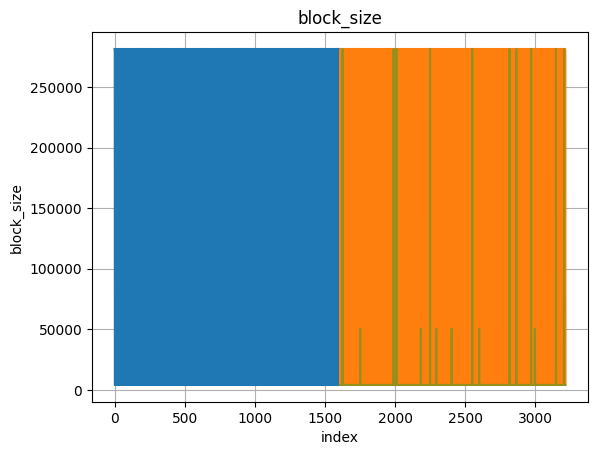

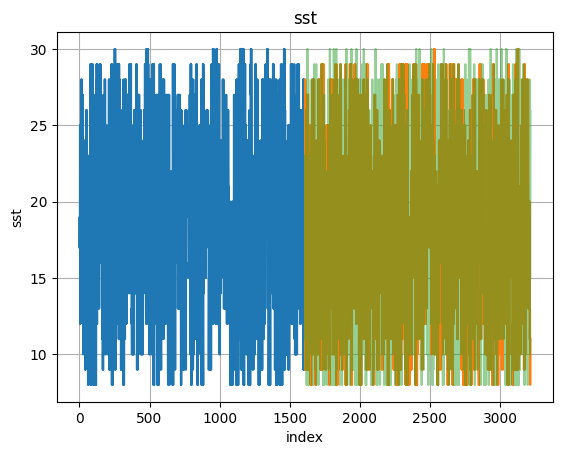

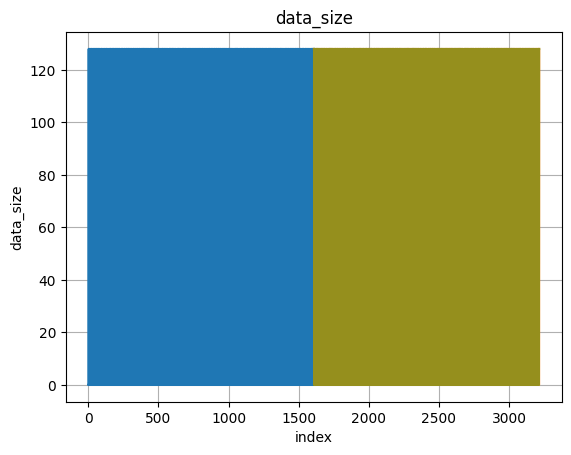

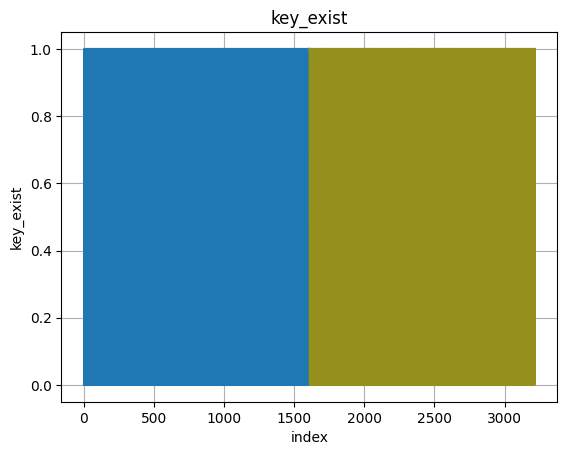

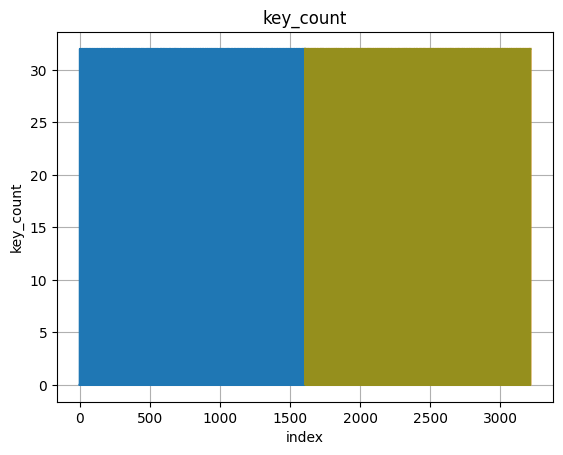

In [ ]:
from google.colab import drive
from prettytable import PrettyTable
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
drive.mount('/content/drive')
warnings.filterwarnings('ignore')
file_path = '/content/drive/MyDrive/aaa/datasets/db_bench/updaterandom_2/bclt.csv'
num_past_measurements = 20
test_ratio_in_percentage = 50
test_ratio = test_ratio_in_percentage / 100
data = pd.read_csv(file_path)
data = data.head(int(np.round(len(data) * 0.001)))
print('length of data: ', len(data))
data = data.reset_index()
test_size = int(np.round(len(data) * test_ratio))
train_data, test_data = data[:-test_size], data[-test_size:]
num_columns = train_data.shape[1]
prediction_indices = range(len(train_data), len(train_data) + test_size)
prediction_data = pd.DataFrame(prediction_indices, columns=['index'], index=prediction_indices)
for col in [column for column in train_data.columns if train_data[column].nunique() == 1]:
    prediction_data[col] = pd.Series(train_data[col].iloc[0]).repeat(test_size).values
columns_not_in_prediction = [col for col in train_data.columns.tolist() if col not in prediction_data.columns.tolist()]
unique_values_dict = {}
for col in columns_not_in_prediction:
    unique_values = train_data[col].nunique()
    unique_values_dict[col] = unique_values
continuous_columns = []
discrete_columns = []
for col, unique_values in unique_values_dict.items():
    if unique_values > 500:
        continuous_columns.append(col)
    else:
        discrete_columns.append(col)
start_index = len(data) - test_size
for col in columns_not_in_prediction:
    for i in range(1, num_past_measurements + 1):
        data[f'{col}_{i}'] = data[col].shift(i * 25)
        if data[f'{col}_{i}'].dtype == 'int64':
            data[f'{col}_{i}'].fillna(-1, inplace=True)
        elif data[f'{col}_{i}'].dtype == 'float64':
            data[f'{col}_{i}'].fillna(-1.0, inplace=True)
        if data[f'{col}_{i}'].dtype != data[col].dtype:
            data[f'{col}_{i}'] = data[f'{col}_{i}'].astype(data[col].dtype)
        train_data.loc[:start_index, f'{col}_{i}'] = data.loc[:start_index, f'{col}_{i}']
        test_data.loc[:start_index, f'{col}_{i}'] = data.loc[:start_index, f'{col}_{i}']
        prediction_data.loc[start_index:, f'{col}_{i}'] = data.loc[start_index:, f'{col}_{i}']
num_rows = int(np.round(len(train_data) * 0.05))
for col in columns_not_in_prediction:
    features = [f'{col}_{i}' for i in range(1, num_columns)]
    X_test = prediction_data[features]
    if col in continuous_columns:
        X_train = train_data[features].values[-num_rows:]
        y_train = train_data[col].values[-num_rows:]
        model = LinearRegression()
    else:
        X_train = train_data[features]
        y_train = train_data[col]
        model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred < -1, -1, y_pred)
    if train_data[col].dtype == np.int64:
        y_pred = np.round(y_pred).astype(np.int64)
    prediction_data[col] = y_pred
columns_to_drop = ['index']
if columns_not_in_prediction:
    start_index = train_data.columns.get_loc(f'{columns_not_in_prediction[0]}_1')
    end_index = train_data.columns.get_loc(f'{columns_not_in_prediction[-1]}_{num_past_measurements}')
    columns_to_drop.extend(data.columns[start_index:end_index + 1])
data = data.drop(columns_to_drop, axis=1)
train_data = train_data.drop(columns_to_drop, axis=1)
test_data = test_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data[train_data.columns]
table = PrettyTable()
table.field_names = ["Column", "Score", "Metric"]
scores = {}
below_average = []
for col in prediction_data.columns:
    if col in continuous_columns:
        score = r2_score(test_data[col], prediction_data[col])
        if score < 0:
            score = 0
        metric = 'R-squared'
    else:
        score = accuracy_score(test_data[col], prediction_data[col])
        metric = 'Accuracy'
    if score <= 0.6:
        below_average.append(col)
    scores[col] = (score, metric)
sorted_scores = sorted(scores.items(), key=lambda x: x[1][0], reverse=True)
for col, (score, metric) in sorted_scores:
    table.add_row([col, f'{(score * 100):.2f}%', metric])
average_score = np.mean([score for score, metric in scores.values()])
table.add_row(["TOTAL", f'{(average_score * 100):.2f}%', 'Total'])
print(table)
for col in below_average:
    plt.figure()
    plt.title(col)
    plt.plot(train_data[col])
    plt.plot(test_data[col])
    plt.plot(prediction_data[col], alpha=0.5)
    plt.xlabel('index')
    plt.ylabel(col)
    plt.grid()
    plt.show()

In [ ]:
from google.colab import drive
from prettytable import PrettyTable
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
drive.mount('/content/drive')
warnings.filterwarnings('ignore')
file_path = '/content/drive/MyDrive/aaa/datasets/db_bench/updaterandom_2/bclt.csv'
num_past_measurements = 20
test_ratio_in_percentage = 50
test_ratio = test_ratio_in_percentage / 100
data = pd.read_csv(file_path)
data = data.head(int(np.round(len(data) * 0.001)))
print('length of data: ', len(data))
data = data.reset_index()
test_size = int(np.round(len(data) * test_ratio))
train_data, test_data = data[:-test_size], data[-test_size:]
num_columns = train_data.shape[1]
prediction_indices = range(len(train_data), len(train_data) + test_size)
prediction_data = pd.DataFrame(prediction_indices, columns=['index'], index=prediction_indices)
for col in [column for column in train_data.columns if train_data[column].nunique() == 1]:
    prediction_data[col] = pd.Series(train_data[col].iloc[0]).repeat(test_size).values
columns_not_in_prediction = [col for col in train_data.columns.tolist() if col not in prediction_data.columns.tolist()]
unique_values_dict = {}
for col in columns_not_in_prediction:
    unique_values = train_data[col].nunique()
    unique_values_dict[col] = unique_values
continuous_columns = []
discrete_columns = []
for col, unique_values in unique_values_dict.items():
    if unique_values > 500:
        continuous_columns.append(col)
    else:
        discrete_columns.append(col)
start_index = len(data) - test_size
for col in columns_not_in_prediction:
    for i in range(1, num_past_measurements + 1):
        data[f'{col}_{i}'] = data[col].shift(i * 25)
        if data[f'{col}_{i}'].dtype == 'int64':
            data[f'{col}_{i}'].fillna(-1, inplace=True)
        elif data[f'{col}_{i}'].dtype == 'float64':
            data[f'{col}_{i}'].fillna(-1.0, inplace=True)
        if data[f'{col}_{i}'].dtype != data[col].dtype:
            data[f'{col}_{i}'] = data[f'{col}_{i}'].astype(data[col].dtype)
        train_data.loc[:start_index, f'{col}_{i}'] = data.loc[:start_index, f'{col}_{i}']
        test_data.loc[:start_index, f'{col}_{i}'] = data.loc[:start_index, f'{col}_{i}']
        prediction_data.loc[start_index:, f'{col}_{i}'] = data.loc[start_index:, f'{col}_{i}']
num_rows = int(np.round(len(train_data) * 0.05))
for col in columns_not_in_prediction:
    features = [f'{col}_{i}' for i in range(1, num_columns)]
    X_test = prediction_data[features]
    if col in continuous_columns:
        X_train = train_data[features].values[-num_rows:]
        y_train = train_data[col].values[-num_rows:]
        model = LinearRegression()
    else:
        X_train = train_data[features]
        y_train = train_data[col]
        model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred < -1, -1, y_pred)
    if train_data[col].dtype == np.int64:
        y_pred = np.round(y_pred).astype(np.int64)
    prediction_data[col] = y_pred
columns_to_drop = ['index']
if columns_not_in_prediction:
    start_index = train_data.columns.get_loc(f'{columns_not_in_prediction[0]}_1')
    end_index = train_data.columns.get_loc(f'{columns_not_in_prediction[-1]}_{num_past_measurements}')
    columns_to_drop.extend(data.columns[start_index:end_index + 1])
data = data.drop(columns_to_drop, axis=1)
train_data = train_data.drop(columns_to_drop, axis=1)
test_data = test_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data[train_data.columns]
table = PrettyTable()
table.field_names = ["Column", "Score", "Metric"]
scores = {}
below_average = []
for col in prediction_data.columns:
    if col in continuous_columns:
        score = r2_score(test_data[col], prediction_data[col])
        if score < 0:
            score = 0
        metric = 'R-squared'
    else:
        score = accuracy_score(test_data[col], prediction_data[col])
        metric = 'Accuracy'
    if score <= 0.6:
        below_average.append(col)
    scores[col] = (score, metric)
sorted_scores = sorted(scores.items(), key=lambda x: x[1][0], reverse=True)
for col, (score, metric) in sorted_scores:
    table.add_row([col, f'{(score * 100):.2f}%', metric])
average_score = np.mean([score for score, metric in scores.values()])
table.add_row(["TOTAL", f'{(average_score * 100):.2f}%', 'Total'])
print(table)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
length of data:  3217
+-----------------+---------+-----------+
|      Column     |  Score  |   Metric  |
+-----------------+---------+-----------+
|      cf_id      | 100.00% |  Accuracy |
|      level      | 100.00% |  Accuracy |
|      caller     | 100.00% |  Accuracy |
|    no_insert    | 100.00% |  Accuracy |
|     table_id    | 100.00% |  Accuracy |
| sequence_number | 100.00% |  Accuracy |
|  block_key_size | 100.00% |  Accuracy |
|     key_size    | 100.00% |  Accuracy |
|   block_offset  | 100.00% |  Accuracy |
|      key_id     |  99.94% | R-squared |
|       time      |  99.34% | R-squared |
|        id       |  99.13% | R-squared |
|    cache_hit    |  92.85% |  Accuracy |
|    data_size    |  52.55% |  Accuracy |
|    key_count    |  52.49% |  Accuracy |
|    block_type   |  51.99% |  Accuracy |
|    key_exist    |  51.68% |  Accuracy |
|    bloc

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
length of data:  3217
+-----------------+---------+-----------+
|      Column     |  Score  |   Metric  |
+-----------------+---------+-----------+
|      cf_id      | 100.00% |  Accuracy |
|      level      | 100.00% |  Accuracy |
|      caller     | 100.00% |  Accuracy |
|    no_insert    | 100.00% |  Accuracy |
|     table_id    | 100.00% |  Accuracy |
| sequence_number | 100.00% |  Accuracy |
|  block_key_size | 100.00% |  Accuracy |
|     key_size    | 100.00% |  Accuracy |
|   block_offset  | 100.00% |  Accuracy |
|       time      |  98.96% | R-squared |
|      key_id     |  93.34% | R-squared |
|        id       |  93.15% | R-squared |
|    cache_hit    |  92.85% |  Accuracy |
|    key_exist    |  51.24% |  Accuracy |
|    key_count    |  50.19% |  Accuracy |
|    block_size   |  50.06% |  Accuracy |
|    block_type   |  49.94% |  Accuracy |
|    data

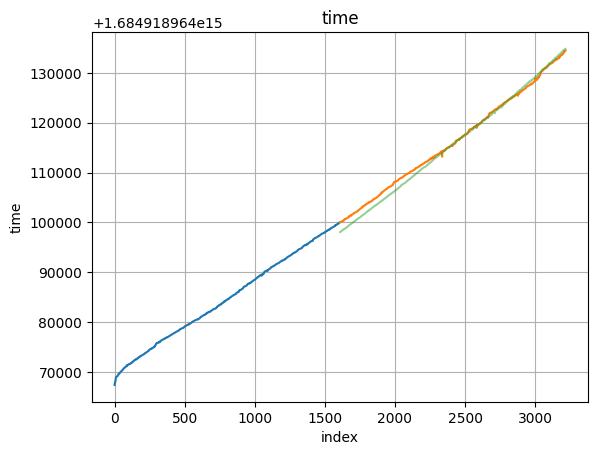

In [ ]:
from google.colab import drive
from prettytable import PrettyTable
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
drive.mount('/content/drive')
warnings.filterwarnings('ignore')
file_path = '/content/drive/MyDrive/aaa/datasets/db_bench/updaterandom_2/bclt.csv'
num_past_measurements = 20
test_ratio_in_percentage = 50
test_ratio = test_ratio_in_percentage / 100
data = pd.read_csv(file_path)
data = data.head(int(np.round(len(data) * 0.001)))
print('length of data: ', len(data))
data = data.reset_index()
min_value = data['time'].min()
data['time'] -= min_value
test_size = int(np.round(len(data) * test_ratio))
train_data, test_data = data[:-test_size], data[-test_size:]
num_columns = train_data.shape[1]
prediction_indices = range(len(train_data), len(train_data) + test_size)
prediction_data = pd.DataFrame(prediction_indices, columns=['index'], index=prediction_indices)
for col in [column for column in train_data.columns if train_data[column].nunique() == 1]:
    prediction_data[col] = pd.Series(train_data[col].iloc[0]).repeat(test_size).values
columns_not_in_prediction = [col for col in train_data.columns.tolist() if col not in prediction_data.columns.tolist()]
unique_values_dict = {}
for col in columns_not_in_prediction:
    unique_values = train_data[col].nunique()
    unique_values_dict[col] = unique_values
continuous_columns = []
discrete_columns = []
for col, unique_values in unique_values_dict.items():
    if unique_values > 500:
        continuous_columns.append(col)
    else:
        discrete_columns.append(col)
start_index = len(data) - test_size
for col in columns_not_in_prediction:
    for i in range(1, num_past_measurements + 1):
        data[f'{col}_{i}'] = data[col].shift(i * 25)
        if data[f'{col}_{i}'].dtype == 'int64':
            data[f'{col}_{i}'].fillna(-1, inplace=True)
        elif data[f'{col}_{i}'].dtype == 'float64':
            data[f'{col}_{i}'].fillna(-1.0, inplace=True)
        if data[f'{col}_{i}'].dtype != data[col].dtype:
            data[f'{col}_{i}'] = data[f'{col}_{i}'].astype(data[col].dtype)
        train_data.loc[:start_index, f'{col}_{i}'] = data.loc[:start_index, f'{col}_{i}']
        test_data.loc[:start_index, f'{col}_{i}'] = data.loc[:start_index, f'{col}_{i}']
        prediction_data.loc[start_index:, f'{col}_{i}'] = data.loc[start_index:, f'{col}_{i}']
num_rows = int(np.round(len(train_data) * 0.05))
for col in columns_not_in_prediction:
    features = [f'{col}_{i}' for i in range(1, num_columns)]
    X_test = prediction_data[features]
    if col in continuous_columns:
        X_train = train_data[features].values[-num_rows:].copy()
        y_train = train_data[col].values[-num_rows:].copy()
        model = MLPRegressor(hidden_layer_sizes=(250, 250), max_iter=1000, random_state=42, activation='identity', solver='adam')
    else:
        X_train = train_data[features].copy()
        y_train = train_data[col].copy()
        model = MLPClassifier(hidden_layer_sizes=(250, 250), max_iter=1000, random_state=42, activation='logistic', solver='adam')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred < -1, -1, y_pred)
    if train_data[col].dtype == np.int64:
        y_pred = np.round(y_pred).astype(np.int64)
    prediction_data[col] = y_pred
columns_to_drop = ['index']
if columns_not_in_prediction:
    start_index = train_data.columns.get_loc(f'{columns_not_in_prediction[0]}_1')
    end_index = train_data.columns.get_loc(f'{columns_not_in_prediction[-1]}_{num_past_measurements}')
    columns_to_drop.extend(data.columns[start_index:end_index + 1])
data = data.drop(columns_to_drop, axis=1)
train_data = train_data.drop(columns_to_drop, axis=1)
test_data = test_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data[train_data.columns]
train_data['time'] += min_value
test_data['time'] += min_value
prediction_data['time'] += min_value
table = PrettyTable()
table.field_names = ["Column", "Score", "Metric"]
scores = {}
below_average = []
for col in prediction_data.columns:
    if col in continuous_columns:
        score = r2_score(test_data[col], prediction_data[col])
        if score < 0:
            score = 0
        metric = 'R-squared'
    else:
        score = accuracy_score(test_data[col], prediction_data[col])
        metric = 'Accuracy'
    if score <= 0.6:
        below_average.append(col)
    scores[col] = (score, metric)
sorted_scores = sorted(scores.items(), key=lambda x: x[1][0], reverse=True)
for col, (score, metric) in sorted_scores:
    table.add_row([col, f'{(score * 100):.2f}%', metric])
average_score = np.mean([score for score, metric in scores.values()])
table.add_row(["TOTAL", f'{(average_score * 100):.2f}%', 'Total'])
print(table)
col = 'time'
plt.figure()
plt.title(col)
plt.plot(train_data[col])
plt.plot(test_data[col])
plt.plot(prediction_data[col], alpha=0.5)
plt.xlabel('index')
plt.ylabel(col)
plt.grid()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
length of data:  3217
51/51 [==============================] - 1s 3ms/step
+-----------------+---------+-----------+
|      Column     |  Score  |   Metric  |
+-----------------+---------+-----------+
|      cf_id      | 100.00% |  Accuracy |
|      level      | 100.00% |  Accuracy |
|      caller     | 100.00% |  Accuracy |
|    no_insert    | 100.00% |  Accuracy |
|     table_id    | 100.00% |  Accuracy |
| sequence_number | 100.00% |  Accuracy |
|  block_key_size | 100.00% |  Accuracy |
|     key_size    | 100.00% |  Accuracy |
|   block_offset  | 100.00% |  Accuracy |
|    key_exist    |  50.06% |  Accuracy |
|    cache_hit    |  7.15%  |  Accuracy |
|       time      |  0.00%  | R-squared |
|     block_id    |  0.00%  | R-squared |
|    block_type   |  0.00%  |  Accuracy |
|    block_size   |  0.00%  |  Accuracy |
|       sst       |  0.00%  |  Accuracy 

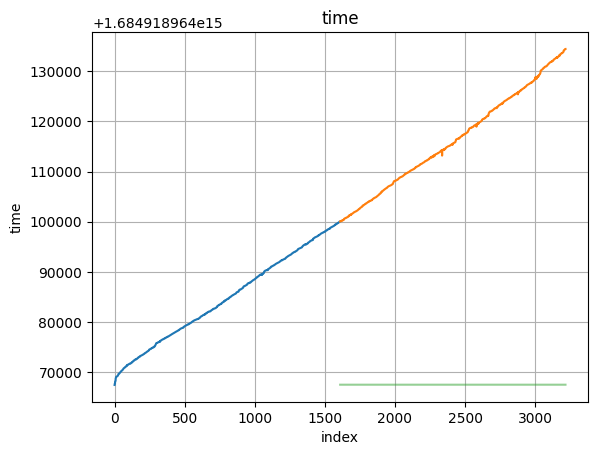

In [ ]:
from google.colab import drive
from keras.models import Sequential
from keras.layers import Dense, LSTM
from prettytable import PrettyTable
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
drive.mount('/content/drive')
warnings.filterwarnings('ignore')
file_path = '/content/drive/MyDrive/aaa/datasets/db_bench/updaterandom_2/bclt.csv'
num_past_measurements = 20
test_ratio_in_percentage = 50
test_ratio = test_ratio_in_percentage / 100
data = pd.read_csv(file_path)
data = data.head(int(np.round(len(data) * 0.001)))
print('length of data: ', len(data))
data = data.reset_index()
min_value = data['time'].min()
data['time'] -= min_value
test_size = int(np.round(len(data) * test_ratio))
train_data, test_data = data[:-test_size], data[-test_size:]
num_columns = train_data.shape[1]
prediction_indices = range(len(train_data), len(train_data) + test_size)
prediction_data = pd.DataFrame(prediction_indices, columns=['index'], index=prediction_indices)
for col in [column for column in train_data.columns if train_data[column].nunique() == 1]:
    prediction_data[col] = pd.Series(train_data[col].iloc[0]).repeat(test_size).values
columns_not_in_prediction = [col for col in train_data.columns.tolist() if col not in prediction_data.columns.tolist()]
unique_values_dict = {}
for col in columns_not_in_prediction:
    unique_values = train_data[col].nunique()
    unique_values_dict[col] = unique_values
continuous_columns = []
discrete_columns = []
for col, unique_values in unique_values_dict.items():
    if unique_values > 500:
        continuous_columns.append(col)
    else:
        discrete_columns.append(col)
start_index = len(data) - test_size
for col in columns_not_in_prediction:
    for i in range(1, num_past_measurements + 1):
        data[f'{col}_{i}'] = data[col].shift(i * 25)
        if data[f'{col}_{i}'].dtype == 'int64':
            data[f'{col}_{i}'].fillna(-1, inplace=True)
        elif data[f'{col}_{i}'].dtype == 'float64':
            data[f'{col}_{i}'].fillna(-1.0, inplace=True)
        if data[f'{col}_{i}'].dtype != data[col].dtype:
            data[f'{col}_{i}'] = data[f'{col}_{i}'].astype(data[col].dtype)
        train_data.loc[:start_index, f'{col}_{i}'] = data.loc[:start_index, f'{col}_{i}']
        test_data.loc[:start_index, f'{col}_{i}'] = data.loc[:start_index, f'{col}_{i}']
        prediction_data.loc[start_index:, f'{col}_{i}'] = data.loc[start_index:, f'{col}_{i}']
num_rows = int(np.round(len(train_data) * 0.05))
for col in columns_not_in_prediction:
    features = [f'{col}_{i}' for i in range(1, num_columns)]
    X_test = prediction_data[features]
    if col in continuous_columns:
        X_train = train_data[features].values[-num_rows:].copy()
        y_train = train_data[col].values[-num_rows:].copy()
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(128))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer='adam')
    else:
        X_train = train_data[features].copy()
        y_train = train_data[col].copy()
        X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(128))
        model.add(Dense(1, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=300, batch_size=128, verbose=0)
    y_pred = model.predict(X_test).reshape(-1)
    y_pred = np.where(y_pred < -1, -1, y_pred)
    if train_data[col].dtype == np.int64:
        y_pred = np.round(y_pred).astype(np.int64)
    prediction_data[col] = y_pred
columns_to_drop = ['index']
if columns_not_in_prediction:
    start_index = train_data.columns.get_loc(f'{columns_not_in_prediction[0]}_1')
    end_index = train_data.columns.get_loc(f'{columns_not_in_prediction[-1]}_{num_past_measurements}')
    columns_to_drop.extend(data.columns[start_index:end_index + 1])
data = data.drop(columns_to_drop, axis=1)
train_data = train_data.drop(columns_to_drop, axis=1)
test_data = test_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data[train_data.columns]
train_data['time'] += min_value
test_data['time'] += min_value
prediction_data['time'] += min_value
table = PrettyTable()
table.field_names = ["Column", "Score", "Metric"]
scores = {}
below_average = []
for col in prediction_data.columns:
    if col in continuous_columns:
        score = r2_score(test_data[col], prediction_data[col])
        if score < 0:
            score = 0
        metric = 'R-squared'
    else:
        score = accuracy_score(test_data[col], prediction_data[col])
        metric = 'Accuracy'
    if score <= 0.6:
        below_average.append(col)
    scores[col] = (score, metric)
sorted_scores = sorted(scores.items(), key=lambda x: x[1][0], reverse=True)
for col, (score, metric) in sorted_scores:
    table.add_row([col, f'{(score * 100):.2f}%', metric])
average_score = np.mean([score for score, metric in scores.values()])
table.add_row(["TOTAL", f'{(average_score * 100):.2f}%', 'Total'])
print(table)
col = 'time'
plt.figure()
plt.title(col)
plt.plot(train_data[col])
plt.plot(test_data[col])
plt.plot(prediction_data[col], alpha=0.5)
plt.xlabel('index')
plt.ylabel(col)
plt.grid()
plt.show()

In [3]:
from google.colab import drive
from keras.models import Sequential
from keras.layers import Dense, LSTM
from prettytable import PrettyTable
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
drive.mount('/content/drive')
warnings.filterwarnings('ignore')
file_path = '/content/drive/MyDrive/aaa/datasets/db_bench/updaterandom_2/bclt.csv'
num_past_measurements = 20
test_ratio_in_percentage = 50
test_ratio = test_ratio_in_percentage / 100
data = pd.read_csv(file_path)
data = data.head(int(np.round(len(data) * 0.001)))
print('length of data: ', len(data))
data = data.reset_index()
min_value = data['time'].min()
data['time'] -= min_value
test_size = int(np.round(len(data) * test_ratio))
train_data, test_data = data[:-test_size], data[-test_size:]
num_columns = train_data.shape[1]
prediction_indices = range(len(train_data), len(train_data) + test_size)
prediction_data = pd.DataFrame(prediction_indices, columns=['index'], index=prediction_indices)
for col in [column for column in train_data.columns if train_data[column].nunique() == 1]:
    prediction_data[col] = pd.Series(train_data[col].iloc[0]).repeat(test_size).values
columns_not_in_prediction = [col for col in train_data.columns.tolist() if col not in prediction_data.columns.tolist()]
unique_values_dict = {}
for col in columns_not_in_prediction:
    unique_values = train_data[col].nunique()
    unique_values_dict[col] = unique_values
continuous_columns = []
discrete_columns = []
for col, unique_values in unique_values_dict.items():
    if unique_values > 500:
        continuous_columns.append(col)
    else:
        discrete_columns.append(col)
start_index = len(data) - test_size
for col in columns_not_in_prediction:
    for i in range(1, num_past_measurements + 1):
        data[f'{col}_{i}'] = data[col].shift(i * 25)
        if data[f'{col}_{i}'].dtype == 'int64':
            data[f'{col}_{i}'].fillna(-1, inplace=True)
        elif data[f'{col}_{i}'].dtype == 'float64':
            data[f'{col}_{i}'].fillna(-1.0, inplace=True)
        if data[f'{col}_{i}'].dtype != data[col].dtype:
            data[f'{col}_{i}'] = data[f'{col}_{i}'].astype(data[col].dtype)
        train_data.loc[:start_index, f'{col}_{i}'] = data.loc[:start_index, f'{col}_{i}']
        test_data.loc[:start_index, f'{col}_{i}'] = data.loc[:start_index, f'{col}_{i}']
        prediction_data.loc[start_index:, f'{col}_{i}'] = data.loc[start_index:, f'{col}_{i}']
num_rows = int(np.round(len(train_data) * 0.05))
for col in columns_not_in_prediction:
    features = [f'{col}_{i}' for i in range(1, num_columns)]
    X_test = prediction_data[features]
    scaler = StandardScaler()
    y_scaler = MinMaxScaler()
    if col in continuous_columns:
        X_train = train_data[features].values[-num_rows:].copy()
        y_train = train_data[col].values[-num_rows:].copy()
        y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_scaled = X_train_scaled.values.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
        X_test_scaled = X_test_scaled.values.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(128))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer='adam')
    else:
        X_train = train_data[features].copy()
        y_train = train_data[col].copy()
        y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_scaled = X_train_scaled.values.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
        X_test_scaled = X_test_scaled.values.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(128))
        model.add(Dense(1, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=300, batch_size=128, verbose=0)
    y_pred = model.predict(X_test).reshape(-1)
    if col in continuous_columns:
        y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    else:
        y_pred = y_pred
        y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.where(y_pred < -1, -1, y_pred)
    if train_data[col].dtype == np.int64:
        y_pred = np.round(y_pred).astype(np.int64)
    prediction_data[col] = y_pred
columns_to_drop = ['index']
if columns_not_in_prediction:
    start_index = train_data.columns.get_loc(f'{columns_not_in_prediction[0]}_1')
    end_index = train_data.columns.get_loc(f'{columns_not_in_prediction[-1]}_{num_past_measurements}')
    columns_to_drop.extend(data.columns[start_index:end_index + 1])
data = data.drop(columns_to_drop, axis=1)
train_data = train_data.drop(columns_to_drop, axis=1)
test_data = test_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data.drop(columns_to_drop, axis=1)
prediction_data = prediction_data[train_data.columns]
train_data['time'] += min_value
test_data['time'] += min_value
prediction_data['time'] += min_value
table = PrettyTable()
table.field_names = ["Column", "Score", "Metric"]
scores = {}
below_average = []
for col in prediction_data.columns:
    if col in continuous_columns:
        score = r2_score(test_data[col], prediction_data[col])
        if score < 0:
            score = 0
        metric = 'R-squared'
    else:
        score = accuracy_score(test_data[col], prediction_data[col])
        metric = 'Accuracy'
    if score <= 0.6:
        below_average.append(col)
    scores[col] = (score, metric)
sorted_scores = sorted(scores.items(), key=lambda x: x[1][0], reverse=True)
for col, (score, metric) in sorted_scores:
    table.add_row([col, f'{(score * 100):.2f}%', metric])
average_score = np.mean([score for score, metric in scores.values()])
table.add_row(["TOTAL", f'{(average_score * 100):.2f}%', 'Total'])
print(table)
col = 'time'
plt.figure()
plt.title(col)
plt.plot(train_data[col])
plt.plot(test_data[col])
plt.plot(prediction_data[col], alpha=0.5)
plt.xlabel('index')
plt.ylabel(col)
plt.grid()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
length of data:  3217


AttributeError: 'numpy.ndarray' object has no attribute 'values'